In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
device = 'cpu'


# %%
# Loading the Navier-Stokes dataset 
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


In [2]:
batch = next(iter(train_loader))
x, y= batch['x'],batch['y']
x.shape

torch.Size([32, 1, 16, 16])

In [3]:
pbatch = data_processor.preprocess(batch)
px, py = pbatch['x'], pbatch['y']


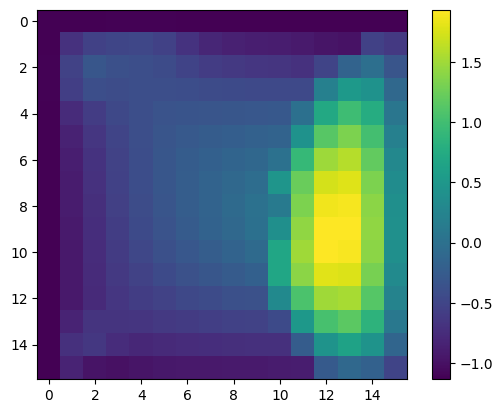

In [4]:
plt.imshow(py[10, 0])
plt.colorbar()
plt.show()

In [5]:
x.shape, y.shape

(torch.Size([32, 1, 16, 16]), torch.Size([32, 1, 16, 16]))

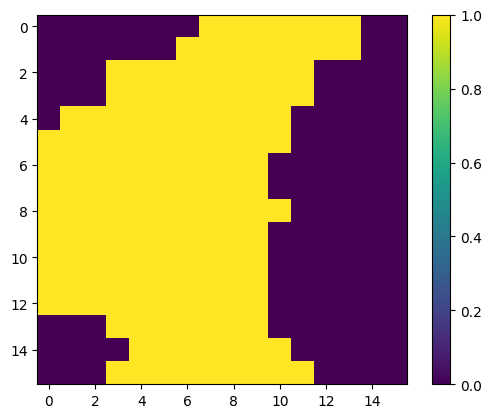

In [6]:
plt.imshow(x[10, 0])
plt.colorbar()
plt.show()

In [7]:

model = FNO(n_modes=(16, 16),
             in_channels=1, 
             out_channels=1, 
             hidden_channels=32, 
             projection_channel_ratio=2, 
             factorization='tucker', 
             rank=0.42)

In [8]:
batch = next(iter(train_loader))

batch['x'].shape, batch['y'].shape
batch['x'].dtype, batch['y'].dtype

# %%
# Training the FNO model on the Navier-Stokes dataset


(torch.float32, torch.float32)

In [ ]:
from turbencrypt.FNO import FourierNO
data_path = "/Users/gilpinlab/turbulence_encryption/data/initconds_test.npz"
random_state = 42
test_size = .2
bs = 10
device = 'cpu'
train_loader, test_loader, data_processor = FourierNO.makeFNO(data_path, random_state, bs, test_size)


In [11]:
batch = next(iter(train_loader))
print(data_processor.in_normalizer, data_processor.out_normalizer)
py = data_processor.out_normalizer(batch['y'])
x = batch['x']
y = batch['y']

StupidTransform() UnitGaussianNormalizer()


In [15]:
batch

{'x': tensor([[[[ 4.3070e-01,  2.2818e-01,  7.2853e-04,  ...,  9.5828e-01,
             7.2802e-01,  5.7039e-01],
           [ 5.7247e-01,  3.4401e-01,  9.7218e-02,  ...,  1.2375e+00,
             1.0902e+00,  9.0341e-01],
           [ 7.8816e-01,  5.0150e-01,  1.8231e-01,  ...,  1.4602e+00,
             1.3213e+00,  1.1629e+00],
           ...,
           [-2.0346e-01, -7.7093e-02, -1.3314e-01,  ...,  3.0324e-01,
             1.0135e-01, -1.6722e-01],
           [-5.3502e-02, -2.1851e-02, -6.5912e-02,  ...,  4.5698e-01,
             2.3364e-01,  3.3528e-02],
           [ 2.2343e-01,  1.6185e-01, -3.3525e-02,  ...,  6.5804e-01,
             3.8719e-01,  2.3235e-01]]],
 
 
         [[[ 4.0494e-02, -2.8386e-03, -9.1287e-02,  ...,  3.0377e-01,
             1.9281e-01,  8.9810e-02],
           [ 2.8232e-02,  4.2649e-03, -9.3528e-02,  ...,  2.9798e-01,
             1.9843e-01,  8.5905e-02],
           [ 1.5555e-02, -1.6748e-02, -1.0580e-01,  ...,  2.9425e-01,
             2.0975e-01,  9.666

In [17]:
data_processor.preprocess(batch)

{'x': tensor([[[[0.5308, 0.5014, 0.4684,  ..., 0.6074, 0.5740, 0.5511],
           [0.5514, 0.5183, 0.4824,  ..., 0.6479, 0.6265, 0.5994],
           [0.5827, 0.5411, 0.4948,  ..., 0.6802, 0.6600, 0.6371],
           ...,
           [0.4388, 0.4572, 0.4490,  ..., 0.5123, 0.4830, 0.4441],
           [0.4606, 0.4652, 0.4588,  ..., 0.5346, 0.5022, 0.4732],
           [0.5008, 0.4918, 0.4635,  ..., 0.5638, 0.5245, 0.5021]]],
 
 
         [[[0.4742, 0.4679, 0.4551,  ..., 0.5124, 0.4963, 0.4814],
           [0.4724, 0.4690, 0.4548,  ..., 0.5116, 0.4971, 0.4808],
           [0.4706, 0.4659, 0.4530,  ..., 0.5110, 0.4988, 0.4824],
           ...,
           [0.4751, 0.4624, 0.4504,  ..., 0.5125, 0.4986, 0.4844],
           [0.4735, 0.4650, 0.4531,  ..., 0.5137, 0.4972, 0.4836],
           [0.4735, 0.4671, 0.4558,  ..., 0.5134, 0.4965, 0.4822]]],
 
 
         [[[0.5853, 0.6253, 0.5819,  ..., 0.3840, 0.3262, 0.3785],
           [0.5884, 0.6336, 0.5942,  ..., 0.4146, 0.3695, 0.4348],
           [0

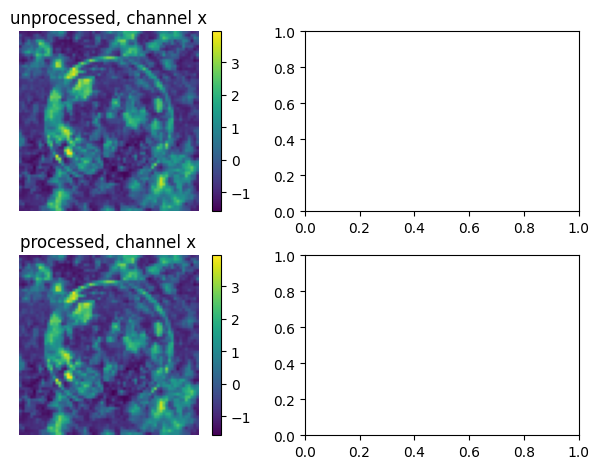

In [19]:
fig, axes = plt.subplots(2,2)
idx = 3
for i, channels in enumerate([y[idx], py[idx]]):
    for j in range(1):
        img = axes[i,j].imshow(channels[j])
        # add colorbar
        cbar = fig.colorbar(img, ax=axes[i,j])
        axes[i,j].set_title(f"{'processed' if i == 1 else 'unprocessed'}, channel {'x' if j == 0 else 'y'}")
        axes[i,j].axis('off')
    
fig.tight_layout()
plt.show()

In [33]:
sum(x.isnan())

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])